In [1]:
import glob
import os
import json
import pickle
import yaml

import numpy as np
import pandas as pd
import pyarrow.parquet as pq

import hist as hist2
import matplotlib.pyplot as plt
import mplhep as hep

plt.style.use(hep.style.CMS)
plt.rcParams.update({"font.size": 20})

import utils

/opt/anaconda3/envs/pyg-coffea/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
! ls ../Jan20_2017

DYJetsToLL_Pt-100To250                  SingleMuon_Run2017F
DYJetsToLL_Pt-250To400                  TTTo2L2Nu
DYJetsToLL_Pt-400To650                  TTToHadronic
DYJetsToLL_Pt-50To100                   TTToSemiLeptonic
DYJetsToLL_Pt-650ToInf                  VBFHToTauTau
GluGluHToTauTau                         VBFHToWWToLNuQQ_M-125_withDipoleRecoil
GluGluHToWWToLNuQQ                      WJetsToLNu_HT-100To200
GluGluHToWW_Pt-200ToInf_M-125           WJetsToLNu_HT-1200To2500
HWminusJ_HToWW_M-125                    WJetsToLNu_HT-200To400
HWplusJ_HToWW_M-125                     WJetsToLNu_HT-2500ToInf
HZJ_HToWW_M-125                         WJetsToLNu_HT-400To600
QCD_Pt_1000to1400                       WJetsToLNu_HT-600To800
QCD_Pt_1400to1800                       WJetsToLNu_HT-70To100
QCD_Pt_170to300                         WJetsToLNu_HT-800To1200
QCD_Pt_1800to2400                       WJetsToQQ_HT-200to400
QCD_Pt_2400to3200                       WJetsToQQ_HT-400to600
QCD_Pt_300to470  

In [4]:
# # counts number of events for a given sample after skimming
# for sample in os.listdir("../Jan20_2017/"):
#     if sample != "SingleMuon_Run2017E":
#         continue
#     out_files = f"{samples_dir}/{sample}/outfiles/"
#     parquet_files = glob.glob(f"{out_files}/*_{ch}.parquet")

#     if not parquet_files:
#         print(f"No parquet file for {sample}")
#         continue                

#     data = pd.read_parquet(parquet_files)
#     not_empty = len(data) > 0

#     print(f"Finding {len(data)} events for {sample}")

# Read parquets
- loads parquet dataframes and combine different pt-bins per sample
- saves the combined dataframe under `events[year][ch][sample]`

In [5]:
combine_samples = {
    # data
    "SingleElectron_": "SingleElectron",    
    "SingleMuon_": "SingleMuon",  
    "EGamma_": "EGamma",    
    
    # signal
    "GluGluHToWW_Pt-200ToInf_M-125": "HWW",    
    "HToWW_M-125": "VH",
    "VBFHToWWToLNuQQ_M-125_withDipoleRecoil": "VBF",
    
    # bkg
    "QCD_Pt": "QCD",
    "DYJets": "DYJets",    
    "WJetsToLNu_": "WJetsLNu",
    "JetsToQQ": "WZQQ",
    "TT": "TTbar",
    "ST_": "SingleTop",
    "WW": "Diboson",
    "WZ": "Diboson",
    "ZZ": "Diboson",
}

In [6]:
samples_dir = "../Jan20_2017"

year = "2017"
channels = ["mu"]

weights = {
    "mu": {
        "weight_genweight": 1,
        "weight_L1Prefiring": 1,
        "weight_pileup": 1,
        "weight_trigger_iso_muon": 1,
        "weight_trigger_noniso_muon": 1,
        "weight_isolation_muon": 1,
        "weight_id_muon": 1,
        "weight_vjets_nominal": 1,
    }
}

In [7]:
samples_json = "plot_configs/samples_pfnano.json"

# get samples from json config
with open(samples_json) as f:
    json_samples = json.load(f)

In [8]:
presel = {
    "mu": {
        "mini-iso": "(( (lep_pt < 55) & (lep_isolation < 0.15) ) | (lep_pt >= 55))",
#         "mini-iso": "( (lep_pt < 55) |  ( (lep_misolation < 0.1) & (lep_pt >= 55) ) )",
#         "iso": "( ( (lep_pt < 55) & (lep_isolation<0.15)) |  (lep_pt >= 55) )",
    }
}

# get year
years = (
    ["2016", "2016APV", "2017", "2018"]
    if year == "Run2"
    else [year]
)    

events_dict = {}
for year in years:
    events_dict[year] = {}
    for ch in channels:
        events_dict[year][ch] = {}
        # get lumi
        with open("../fileset/luminosity.json") as f:
            luminosity = json.load(f)[ch][year]

        ### get samples
        samples = []
        for key, value in json_samples[year][ch].items():
            if value == 1:
                samples.append(key)
#         samples = os.listdir("../Jan20_2017/")

        for sample in samples:
            
            ### get a combined label to combine samples of the same process
            for key in combine_samples:
                if key in sample:
                    sample_to_use = combine_samples[key]
                    break
                else:
                    sample_to_use = sample
            
            if sample_to_use != "HWW":
                continue
                    
            is_data = False
            if sample_to_use == "SingleMuon":
                is_data = True
                
            print(f"Finding {sample} samples and should combine them under {sample_to_use}")

            out_files = f"{samples_dir}/{sample}/outfiles/"
            parquet_files = glob.glob(f"{out_files}/*_{ch}.parquet")
            pkl_files = glob.glob(f"{out_files}/*.pkl")

            if not parquet_files:
                print(f"No parquet file for {sample}")
                continue                
                
            data = pd.read_parquet(parquet_files)
            not_empty = len(data) > 0

            # apply selection
            print("---> Applying preselection.")
            for selection in presel[ch]:
                print(f"applying {selection} selection on {len(data)} events")
                data = data.query(presel[ch][selection])  
            print("---> Done with preselection.")

            # get event_weight
            if not is_data:       
                print("---> Accumulating event weights.")                
                event_weight = utils.get_xsecweight(pkl_files, year, sample, is_data, luminosity)
                for w in weights[ch]:
                    if w not in data.keys():
                        print(f"{w} weight is not stored in parquet")
                        continue
                    event_weight *= data[w]
                print("---> Done with accumulating event weights.")                       
            else:
                event_weight = np.ones_like(data["fj_pt"])

            data["event_weight"] = event_weight

            print(f"Will fill the {sample_to_use} dataframe with the remaining {len(data)} events")
            print(f"tot event weight {data['event_weight'].sum()} \n")
            
            # fill the big dataframe
            if sample_to_use not in events_dict[year][ch].keys():
                events_dict[year][ch][sample_to_use] = data
            else:
                events_dict[year][ch][sample_to_use] = pd.concat([events_dict[year][ch][sample_to_use], data])

Finding GluGluHToWW_Pt-200ToInf_M-125 samples and should combine them under HWW
---> Applying preselection.
applying mini-iso selection on 14901 events
---> Done with preselection.
---> Accumulating event weights.
weight_vjets_nominal weight is not stored in parquet
---> Done with accumulating event weights.
Will fill the HWW dataframe with the remaining 14439 events
tot event weight 117.63909025507881 



In [9]:
events_dict.keys()

dict_keys(['2017'])

In [10]:
events_dict["2017"].keys()

dict_keys(['mu'])

In [11]:
events_dict["2017"]["mu"].keys()

dict_keys(['HWW'])

# Plot histograms

In [12]:
# plot histograms
color_by_sample = {
    "HWW": "coral",
    "ttHToNonbb_M125": "tab:olive",
    "VH": "tab:brown",
    "VBF": "tab:gray",

    "DYJets": "tab:purple",
    "QCD": "tab:orange",
    "Diboson": "orchid",    
    "WJetsLNu": "tab:green",
    "TTbar": "tab:blue",
    "WZQQ": "salmon",
    "SingleTop": "tab:cyan",
    
    "WplusHToTauTau": "tab:cyan",
    "WminusHToTauTau": "tab:cyan",
    "ttHToTauTau": "tab:cyan",
    "GluGluHToTauTau": "tab:cyan",
    "ZHToTauTau": "tab:cyan",
    "VBFHToTauTau": "tab:cyan",
}

plot_labels = {
    "HWW": "ggH(WW)-Pt200",    
    "ttHToNonbb_M125": "ttH(WW)",
    "VH": "VH(WW)",
    "VBF": r"VBFH(WW) $(qq\ell\nu)$",
    
    "DYJets": r"Z$(\ell\ell)$+jets",    
    "QCD": "Multijet",
    "Diboson": "VV",
    "WJetsLNu": r"W$(\ell\nu)$+jets",
    "TTbar": r"$t\bar{t}$+jets",
    "WZQQ": r"W/Z$(qq)$",
    "SingleTop": r"Single Top",
    
    "WplusHToTauTau": "WplusHToTauTau",
    "WminusHToTauTau": "WminusHToTauTau",
    "ttHToTauTau": "ttHToTauTau",
    "GluGluHToTauTau": "GluGluHToTauTau",
    "ZHToTauTau": "ZHToTauTau",
    "VBFHToTauTau": "VBFHToTauTau"
}

label_by_ch = {
    "ele": "Electron",
    "mu": "Muon",
}

# this is actually no longer by channel since I don't have channels for VH, but leave the name for now, since 2018 is different than other years:w
data_by_ch = {
    "ele": "SingleElectron",
    "mu": "SingleMuon",
    "had": "JetHT",
    "DoubleMuon": "DoubleMuon",
    "MuonEG": "MuonEG",
    "DoubleEG": "DoubleEG",
}
data_by_ch_2018 = {
    "ele": "EGamma",  # i guess there was no single electron for this year, so cristina used eGamma instead of single electron?
    "mu": "SingleMuon",
    "had": "JetHT",
    "DoubleMuon": "DoubleMuon",
    "MuonEG": "MuonEG",
}

signal_by_ch = {
    "ele": [
        "HWW",        
        "ttHToNonbb_M125",
        "VH",
        "VBFH",
    ],
    "mu": [
        "HWW",        
        "ttHToNonbb_M125",
        "VH",
        "VBF"
    ],
}

In [13]:
data["fj_H_VV_isVlepton"]

0        True
1        True
2        True
3        True
4        True
         ... 
14896    None
14897    True
14898    True
14899    True
14900    True
Name: fj_H_VV_isVlepton, Length: 14439, dtype: object

In [14]:
num_events = len(data["fj_H_VV_isVlepton"])
print(f"num_events passing selection {num_events}")

num_events passing selection 14439


In [15]:
num_lep_from_W = (data["fj_H_VV_isVlepton"].values==True).sum()
print(f"num_events where canididatelep comes from W {num_lep_from_W}")

num_events where canididatelep comes from W 6457


In [16]:
num_lep_from_Wstar = (data["fj_H_VV_isVlepton"].values==False).sum()
print(f"num_events where canididatelep comes from W* {num_lep_from_Wstar}")

num_events where canididatelep comes from W* 6253


In [17]:
num_events - num_lep_from_W - num_lep_from_Wstar

1729

In [18]:
data["fj_pt"][data["fj_H_VV_isVlepton"]==True]

0        225.375
1        338.750
2        348.500
3        279.750
4        275.500
          ...   
14892    327.000
14897    256.500
14898    209.250
14899    250.375
14900    225.375
Name: fj_pt, Length: 6457, dtype: float32

In [19]:
json_vars = {
  "mu": {
#     "lep_fj_m": 1,
    "fj_pt": 1,
#     "lep_pt": 1,
#     "fj_msoftdrop": 1,
#     "fj_bjets_ophem": 1,
#     "fj_bjets": 1,
#     "lep_isolation_lowpt": 1,
#     "lep_isolation_highpt": 1,
#     "lep_misolation_lowpt": 1,
#     "lep_misolation_highpt": 1,
#     "lep_fj_dr": 1,
#     "lep_met_mt": 1,
#     "ht": 1,
#     "met": 1,
#     "met_fj_dphi": 1,
#     "nfj": 1,
#     "nj": 1,
#     "deta": 1,
#     "mjj": 1,
  },
  "ele": {
    "lep_fj_m": 1,
    "fj_pt": 1,
    "lep_pt": 1
  }
}

In [20]:
year_ = "2017"
ch_ = "mu"

### get samples_to_plot
samples_to_plot = ["HWW"]

var = "lep_pt"

# fill histograms
h = hist2.Hist(
    utils.axis_dict[var],
    hist2.axis.Boolean(name="from_W")        
)

for sample in samples_to_plot:
    h.fill(
        var=events_dict[year_][ch_][sample][var],
        from_W=events_dict[year_][ch_][sample]["fj_H_VV_isVlepton"]==True,
        weight=events_dict[year_][ch_][sample]["event_weight"]
    )

h       

Hist(
  Regular(40, 30, 450, name='var', label='Lepton $p_T$ [GeV]'),
  Boolean(name='from_W', label='from_W'),
  storage=Double()) # Sum: 117.63909025507877

Text(0, 1, 'Events')

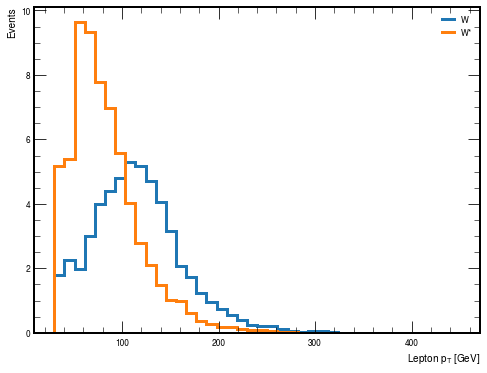

In [21]:
plt.rcParams.update({"font.size": 20})

fig, ax = plt.subplots(figsize=(8, 6))

# plot the signal (times 10)
hep.histplot(
    h[{"from_W": 1}],
    ax=ax,
    label="W",
    linewidth=3,
)
# plot the signal (times 10)
hep.histplot(
    h[{"from_W": 0}],
    ax=ax,
    label="W*",
    linewidth=3,
)
     
ax.legend()
ax.set_ylabel("Events")

In [22]:
year_ = "2017"
ch_ = "mu"

### get vars_to_plot
vars_to_plot = []
for key, value in json_vars[ch_].items():
    if value == 1:
        vars_to_plot.append(key)    
# 
### get samples_to_plot
samples_to_plot = list(events_dict[year_][ch_].keys())
# samples_to_plot = ["GluGluHToWW", "QCD", "TTbar"]

# fill histograms
hists = {}
for var in vars_to_plot:

    hists[var] = hist2.Hist(
        hist2.axis.StrCategory([], name="samples", growth=True),
        utils.axis_dict[var],
    )

    for sample in samples_to_plot:
        hists[var].fill(
            samples=sample,
            var=events_dict[year_][ch_][sample][var],
            weight=events_dict[year_][ch_][sample]["event_weight"]
        )

hists["fj_pt"][{"samples": "HWW"}]        

Hist(Regular(30, 200, 1000, name='var', label='Jet $p_T$ [GeV]'), storage=Double()) # Sum: 117.63145146549547 (117.63909025507881 with flow)

In [23]:
year_ = "2017"
ch_ = "mu"

### get vars_to_plot
vars_to_plot = []
for key, value in json_vars[ch_].items():
    if value == 1:
        vars_to_plot.append(key)    
# 
### get samples_to_plot
samples_to_plot = list(events_dict[year_][ch_].keys())
# samples_to_plot = ["GluGluHToWW", "QCD", "TTbar"]

# fill histograms
hists = {}
for var in vars_to_plot:

    hists[var] = hist2.Hist(
        hist2.axis.StrCategory([], name="samples", growth=True),
        utils.axis_dict[var],
    )

    for sample in samples_to_plot:
        hists[var].fill(
            samples=sample,
            var=events_dict[year_][ch_][sample][var],
            weight=events_dict[year_][ch_][sample]["event_weight"]
        )

hists["fj_pt"][{"samples": "HWW"}]        

Hist(Regular(30, 200, 1000, name='var', label='Jet $p_T$ [GeV]'), storage=Double()) # Sum: 117.63145146549547 (117.63909025507881 with flow)

In [24]:
def plot_hists(hists, vars_to_plot, add_data = True, logy = True, add_soverb = True, only_sig = False):
    # data label
    data_label = data_by_ch[ch]
    if year == "2018":
        data_label = data_by_ch_2018[ch]

    # luminosity
    with open("../fileset/luminosity.json") as f:
        luminosity = json.load(f)[ch_][year_]
        luminosity = luminosity / 1000.0

    #     if year_ == "Run2":
    #         data_label = "Data"

    for var in vars_to_plot:
        if var not in hists.keys():
            print(f"{var} not stored in hists")
            continue

        print(f"Will plot {var} histogram")

        # get histograms
        h = hists[var]

        if (h.shape[0] == 0):  # skip empty histograms (such as lepton_pt for hadronic channel)
            print("Empty histogram ", var)
            continue

        # get samples existing in histogram
        samples = [h.axes[0].value(i) for i in range(len(h.axes[0].edges))]
        signal_labels = [label for label in samples if label in signal_by_ch[ch]]
        bkg_labels = [
            label
            for label in samples
            if (label and label != data_label and label not in signal_labels)
        ]

        # get total yield of backgrounds per label
        # (sort by yield in fixed fj_pt histogram after pre-sel)        
        order_dic = {}
        for bkg_label in bkg_labels:
            if "fj_pt" in hists.keys():
                order_dic[plot_labels[bkg_label]] = hists["fj_pt"][{"samples": bkg_label}].sum()
            else:
                order_dic[plot_labels[bkg_label]] = hists[var][{"samples": bkg_label}].sum()
            
        # data
        data = None
        if data_label in h.axes[0]:
            data = h[{"samples": data_label}]

        # signal
        signal = [h[{"samples": label}] for label in signal_labels]
        # scale signal for non-log plots
        if logy:
            mult_factor = 1
        else:
            mult_factor = 100
        signal_mult = [s * mult_factor for s in signal]

        # background
        bkg = [h[{"samples": label}] for label in bkg_labels]

        if add_data and data and len(bkg) > 0:
            if add_soverb and len(signal) > 0:
                fig, (ax, rax, sax) = plt.subplots(
                    nrows=3,
                    ncols=1,
                    figsize=(8, 8),
                    gridspec_kw={"height_ratios": (4, 1, 1), "hspace": 0.07},
                    sharex=True,
                )
            else:
                fig, (ax, rax) = plt.subplots(
                    nrows=2,
                    ncols=1,
                    figsize=(8, 8),
                    gridspec_kw={"height_ratios": (4, 1), "hspace": 0.07},
                    sharex=True,
                )
                sax = None
        else:
            if add_soverb and len(signal) > 0:
                fig, (ax, sax) = plt.subplots(
                    nrows=2,
                    ncols=1,
                    figsize=(8, 8),
                    gridspec_kw={"height_ratios": (4, 1), "hspace": 0.07},
                    sharex=True,
                )
                rax = None
            else:
                fig, ax = plt.subplots(1, 1)
                rax = None
                sax = None

        errps = {
            "hatch": "////",
            "facecolor": "none",
            "lw": 0,
            "color": "k",
            "edgecolor": (0, 0, 0, 0.5),
            "linewidth": 0,
            "alpha": 0.4,
        }

        # sum all of the background
        if len(bkg) > 0:
            tot = bkg[0].copy()
            for i, b in enumerate(bkg):
                if i > 0:
                    tot = tot + b

            tot_val = tot.values()
            tot_val_zero_mask = tot_val == 0
            tot_val[tot_val_zero_mask] = 1

            tot_err = np.sqrt(tot_val)
            tot_err[tot_val_zero_mask] = 0

            # print(f'Background yield: ',tot_val,np.sum(tot_val))

        if add_data and data:
            data_err_opts = {
                "linestyle": "none",
                "marker": ".",
                "markersize": 10.0,
                "elinewidth": 1,
            }
            hep.histplot(
                data,
                ax=ax,
                histtype="errorbar",
                color="k",
                capsize=4,
                yerr=True,
                label=data_label,
                **data_err_opts,
            )

            if len(bkg) > 0:
                from hist.intervals import ratio_uncertainty

                data_val = data.values()
                data_val[tot_val_zero_mask] = 1

                yerr = ratio_uncertainty(data_val, tot_val, "poisson")

                hep.histplot(
                    data_val / tot_val,
                    tot.axes[0].edges,
                    # yerr=np.sqrt(data_val) / tot_val,
                    yerr=yerr,
                    ax=rax,
                    histtype="errorbar",
                    color="k",
                    capsize=4,
                )

                rax.axhline(1, ls="--", color="k")
                rax.set_ylim(0.2, 1.8)
                # rax.set_ylim(0.7, 1.3)

        # plot the background
        if len(bkg) > 0 and not only_sig:
            hep.histplot(
                bkg,
                ax=ax,
                stack=True,
                sort="yield",
                edgecolor="black",
                linewidth=1,
                histtype="fill",
                label=[plot_labels[bkg_label] for bkg_label in bkg_labels],
                color=[color_by_sample[bkg_label] for bkg_label in bkg_labels],
            )
            ax.stairs(
                values=tot.values() + tot_err,
                baseline=tot.values() - tot_err,
                edges=tot.axes[0].edges,
                **errps,
                label="Stat. unc.",
            )

        # plot the signal (times 10)
        if len(signal) > 0:
            tot_signal = None
            for i, sig in enumerate(signal_mult):
                lab_sig_mult = f"{mult_factor} * {plot_labels[signal_labels[i]]}"
                if mult_factor == 1:
                    lab_sig_mult = f"{plot_labels[signal_labels[i]]}"
                hep.histplot(
                    sig,
                    ax=ax,
                    label=lab_sig_mult,
                    linewidth=3,
                    color=color_by_sample[signal_labels[i]],
                )

                if tot_signal == None:
                    tot_signal = signal[i].copy()
                else:
                    tot_signal = tot_signal + signal[i]

            # plot the total signal (w/o scaling)
            hep.histplot(
                tot_signal, ax=ax, label=f"ggF+VBF+VH+ttH", linewidth=3, color="tab:red"
            )
            # add MC stat errors
            ax.stairs(
                values=tot_signal.values() + np.sqrt(tot_signal.values()),
                baseline=tot_signal.values() - np.sqrt(tot_signal.values()),
                edges=sig.axes[0].edges,
                **errps,
            )

            if sax is not None:
                totsignal_val = tot_signal.values()
                # replace values where bkg is 0
                totsignal_val[tot_val == 0] = 0
                soverb_val = totsignal_val / np.sqrt(tot_val)
                hep.histplot(
                    soverb_val,
                    tot_signal.axes[0].edges,
                    label="Total Signal",
                    ax=sax,
                    linewidth=3,
                    color="tab:red",
                )

                # integrate soverb in a given range for lep_fj_m (which, intentionally, is the first variable we pass)
                if var == "lep_fj_m":
                    bin_array = tot_signal.axes[0].edges[
                        :-1
                    ]  # remove last element since bins have one extra element
                    range_max = 150
                    range_min = 0

                    condition = (bin_array >= range_min) & (bin_array <= range_max)

                    s = totsignal_val[
                        condition
                    ].sum()  # sum/integrate signal counts in the range
                    b = np.sqrt(
                        tot_val[condition].sum()
                    )  # sum/integrate bkg counts in the range and take sqrt

                    soverb_integrated = round((s / b).item(), 2)
                    sax.legend(title=f"S/sqrt(B) (in 0-150)={soverb_integrated}")

        ax.set_ylabel("Events")
        if sax is not None:
            ax.set_xlabel("")
            if rax is not None:
                rax.set_xlabel("")
                rax.set_ylabel("Data/MC", fontsize=20)
            sax.set_ylabel(r"S/$\sqrt{B}$", fontsize=20)
#             sax.set_xlabel(f"{utils.axis_dict[var].label}")
            sax.set_xlabel(f"{h.axes[-1].label}")   # assumes the variable to be plotted is at the last axis
            
        elif rax is not None:
            ax.set_xlabel("")
#             rax.set_xlabel(f"{utils.axis_dict[var].label}")
            rax.set_xlabel(f"{h.axes[-1].label}")    # assumes the variable to be plotted is at the last axis
            
            rax.set_ylabel("Data/MC", fontsize=20)

        # get handles and labels of legend
        handles, labels = ax.get_legend_handles_labels()

        # append legend labels in order to a list
        summ = []
        for label in labels[: len(bkg_labels)]:
            summ.append(order_dic[label])
        # get indices of labels arranged by yield
        order = []
        for i in range(len(summ)):
            order.append(np.argmax(np.array(summ)))
            summ[np.argmax(np.array(summ))] = -100

        # plot data first, then bkg, then signal
        hand = [handles[-1]] + [handles[i] for i in order] + handles[len(bkg) : -1]
        lab = [labels[-1]] + [labels[i] for i in order] + labels[len(bkg) : -1]

        ax.legend(
            [hand[idx] for idx in range(len(hand))],
            [lab[idx] for idx in range(len(lab))],
            bbox_to_anchor=(1.05, 1),
            loc="upper left",
            title=f"{label_by_ch[ch]} Channel",
        )

        if logy:
            ax.set_yscale("log")
            ax.set_ylim(10)

        hep.cms.lumitext(
            "%.1f " % luminosity + r"fb$^{-1}$ (13 TeV)", ax=ax, fontsize=20
        )
        hep.cms.text("Work in Progress", ax=ax, fontsize=15)

Will plot fj_pt histogram


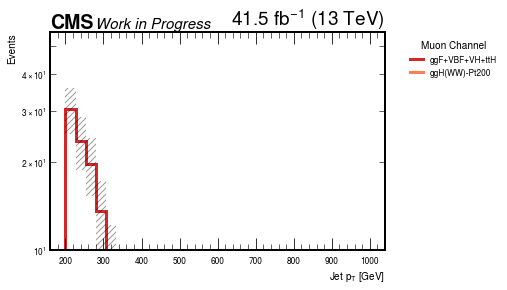

In [28]:
plot_hists(hists, vars_to_plot, add_data = True, logy = True, add_soverb = False, only_sig = False)

# Make ROCs

In [29]:
labels = {
    "label_H_WqqWqq_0c": "( (fj_H_VV_4q==1) & (fj_nprongs==4) & (fj_ncquarks==0) )",
    "label_H_WqqWqq_1c": "( (fj_H_VV_4q==1) & (fj_nprongs==4) & (fj_ncquarks==1) )",
    "label_H_WqqWqq_2c": "( (fj_H_VV_4q==1) & (fj_nprongs==4) & (fj_ncquarks==2) )",
    "label_H_WqqWq_0c": "( (fj_H_VV_4q==1) & (fj_nprongs==3) & (fj_ncquarks==0) )",
    "label_H_WqqWq_1c": "( (fj_H_VV_4q==1) & (fj_nprongs==3) & (fj_ncquarks==1) )",
    "label_H_WqqWq_2c": "( (fj_H_VV_4q==1) & (fj_nprongs==3) & (fj_ncquarks==2) )",
    "label_H_WW2lep": "(fj_lepinprongs==2)",
    "label_H_WW0lep": "(fj_lepinprongs==0)",
    "label_H_WqWev": "(fj_H_VV_elenuqq==1) & (fj_nprongs==1) & (fj_lepinprongs==1)",
    "label_H_WqWmv": "(fj_H_VV_munuqq==1) & (fj_nprongs==1) & (fj_lepinprongs==1)",
    "label_H_WqqWev_0c": "( (fj_H_VV_elenuqq==1) & (fj_nprongs>=2) & (fj_ncquarks==0) )",
    "label_H_WqqWev_1c": "( (fj_H_VV_elenuqq==1) & (fj_nprongs>=2) & (fj_ncquarks==1) )",
    "label_H_WqqWmv_0c": "( (fj_H_VV_munuqq==1) & (fj_nprongs>=2) & (fj_ncquarks==0) )",
    "label_H_WqqWmv_1c": "( (fj_H_VV_munuqq==1) & (fj_nprongs>=2) & (fj_ncquarks==1) )",
    "label_H_WqqWtauev_0c": "( (fj_H_VV_leptauelvqq==1) & (fj_nprongs>=2) & (fj_ncquarks==0) )",
    "label_H_WqqWtauev_1c": "( (fj_H_VV_leptauelvqq==1) & (fj_nprongs>=2) & (fj_ncquarks==1) )",
    "label_H_WqqWtaumv_0c": "( (fj_H_VV_leptaumuvqq==1) & (fj_nprongs>=2) & (fj_ncquarks==0) )",
    "label_H_WqqWtaumv_1c": "( (fj_H_VV_leptaumuvqq==1) & (fj_nprongs>=2) & (fj_ncquarks==1) )",
    "label_H_WqqWtauhv_0c": "( (fj_H_VV_hadtauvqq==1) & (fj_nprongs>=2) & (fj_ncquarks==0) )",
    "label_H_WqqWtauhv_1c": "( (fj_H_VV_hadtauvqq==1) & (fj_nprongs>=2) & (fj_ncquarks==1) )",
    
    "label_Top_nob": "(fj_Top_bmerged==0)",
    "label_Top_bWqq_0c": "( (fj_Top_2q==1) & (fj_nprongs == 2)  & (fj_Top_bmerged==1) & (fj_ncquarks==0) )",
    "label_Top_bWqq_1c": "( (fj_Top_2q==1) & (fj_nprongs == 2) & (fj_Top_bmerged==1) & (fj_ncquarks==1) )",
    "label_Top_bWq_0c": "( (fj_Top_2q==1) & (fj_nprongs == 1) & (fj_Top_bmerged==1) & (fj_ncquarks==0) )",
    "label_Top_bWq_1c": "( (fj_Top_2q==1) & (fj_nprongs == 1) & (fj_Top_bmerged==1) & (fj_ncquarks==1) )",
    "label_Top_bWev": "( (fj_Top_elenu==1) & (fj_Top_bmerged==1) )",
    "label_Top_bWmv": "( (fj_Top_munu==1) & (fj_Top_bmerged==1) )",
    "label_Top_bWtauhv": "( (fj_Top_hadtauvqq==1) & (fj_Top_bmerged==1) )",
    "label_Top_bWtauev": "( (fj_Top_leptauelvnu==1) & (fj_Top_bmerged==1) )",
    "label_Top_bWtaumv": "( (fj_Top_leptaumuvnu==1) & (fj_Top_bmerged==1) )",
    
    "label_W_ev": "(fj_V_elenu==1) & (fj_lepinprongs==1)",
    "label_W_ev_0lep": "(fj_V_elenu==1) & (fj_lepinprongs==0)",
    "label_W_mv": "(fj_V_munu==1) & (fj_lepinprongs==1)",
    "label_W_mv_0lep": "(fj_V_munu==1) & (fj_lepinprongs==0)",
    "label_W_tauv": "(fj_V_taunu==1) & (fj_lepinprongs==1)",
    "label_W_tauv_0lep": "(fj_V_taunu==1) & (fj_lepinprongs==0)",
    "label_Z_2lep": "(fj_lepinprongs==2)",
    "label_Z_1lep": "(fj_lepinprongs==1)",
}

match_labels = {
    "HWW": "fj_H_VV_isMatched",
    "TTbar": "fj_Top_isMatched",
    "SingleTop": "fj_Top_isMatched",    
    "WJetsLNu": "fj_V_isMatched",
    "DYJets": "fj_V_isMatched",
}

In [30]:
! ls ../Jan20_2017/ST_tW_top_5f_inclusiveDecays/outfiles

0-40.pkl          0-40_mu.parquet   40-80_ele.parquet
0-40_ele.parquet  40-80.pkl         40-80_mu.parquet


In [31]:
for key in pd.read_parquet("../Jan20_2017/ST_tW_top_5f_inclusiveDecays/outfiles/0-40_mu.parquet").keys():
    print(key)

met
ht
nfj
nj
deta
mjj
weight
weight_genweight
weight_L1Prefiring
weight_pileup
mu_mvaId
mu_highPtId
weight_trigger_iso_muon
weight_trigger_noniso_muon
weight_isolation_muon
weight_id_muon
weight_mu
fj_pt
fj_msoftdrop
fj_bjets_ophem
fj_bjets
lep_pt
lep_isolation
lep_misolation
lep_fj_m
lep_fj_dr
lep_met_mt
met_fj_dphi
rec_higgs_m
fj_PN_v2_noreg_label_H_WqqWqq_0c
fj_PN_v2_noreg_label_H_WqqWqq_1c
fj_PN_v2_noreg_label_H_WqqWqq_2c
fj_PN_v2_noreg_label_H_WqqWq_0c
fj_PN_v2_noreg_label_H_WqqWq_1c
fj_PN_v2_noreg_label_H_WqqWq_2c
fj_PN_v2_noreg_label_H_WqqWev_0c
fj_PN_v2_noreg_label_H_WqqWev_1c
fj_PN_v2_noreg_label_H_WqqWmv_0c
fj_PN_v2_noreg_label_H_WqqWmv_1c
fj_PN_v2_noreg_label_H_WqqWtauev_0c
fj_PN_v2_noreg_label_H_WqqWtauev_1c
fj_PN_v2_noreg_label_H_WqqWtaumv_0c
fj_PN_v2_noreg_label_H_WqqWtaumv_1c
fj_PN_v2_noreg_label_H_WqqWtauhv_0c
fj_PN_v2_noreg_label_H_WqqWtauhv_1c
fj_PN_v2_noreg_label_H_bb
fj_PN_v2_noreg_label_H_cc
fj_PN_v2_noreg_label_H_ss
fj_PN_v2_noreg_label_H_qq
fj_PN_v2_noreg_label_

In [37]:
# aesthetics
nicex_scores = {
    "hww_vs_qcd": r"$\frac{H_{WqqW(\ell\tau)\nu}}{H_{WqqW(e\tau)\nu}+QCD}$",
    "hww_vs_top": r"$\frac{H_{WqqW(\ell\tau)\nu}}{H_{WqqW(e\tau)\nu}+Top_{bW(\ell\tau\nu)}}$",
}

nice_channel = {
    "mu": "Muon",
    "ele": "Electron"
}

import matplotlib.colors as mcolors
color_by_label = {}
for i,label in enumerate(labels):
    color_by_label[label] = list(mcolors.TABLEAU_COLORS.values())[i%10]

color_by_label["unmatched"] = "r"

In [38]:
# labels to check per sample
labels_per_sample = {
    "ele": {
        "TTbar": [
            "label_Top_bWev",
            "label_Top_bWtauev",
            "label_Top_nob",
        ],    
        "HWW": [
            "label_H_WqqWev_0c","label_H_WqqWev_1c",
        ],
        "WJetsLNu": [
            "label_W_ev",#"label_W_ev_0lep",
            "label_W_tauv",#"label_W_tauv_0lep",
        ],
#         "DYJets": [
#             "label_Z_2lep",
#             "label_Z_1lep",
#         ],
        "QCD": [],
    },
    "mu": {
        "TTbar": [
            "label_Top_bWmv",
            "label_Top_bWtaumv",
            "label_Top_nob",
        ],
        "SingleTop": [
            "label_Top_bWev",
            "label_Top_bWtauev",
            "label_Top_nob",
        ],            
        "HWW": [
            "label_H_WqqWmv_0c","label_H_WqqWmv_1c",
            "label_H_WqqWtaumv_0c","label_H_WqqWtaumv_1c",
        ], 
        "WJetsLNu": [
            "label_W_mv",#"label_W_mv_0lep",
            "label_W_tauv",#"label_W_tauv_0lep",
        ],
#         "DYJets": [
#             "label_Z_2lep",
#             "label_Z_1lep",
#         ],
        "QCD": [],
        }
}

In [39]:
presel = {
    "mu": {
        "mini-iso": "(( (lep_pt < 55) & (lep_isolation < 0.15) ) | (lep_pt >= 55))",
#         "mini-iso": "( (lep_pt < 55) |  ( (lep_misolation < 0.1) & (lep_pt >= 55) ) )",
#         "iso": "( ( (lep_pt < 55) & (lep_isolation<0.15)) |  (lep_pt >= 55) )",
    }
}

# scores definition
hwwev = ["fj_PN_label_H_WqqWev_0c","fj_PN_label_H_WqqWev_1c","fj_PN_label_H_WqqWtauev_0c","fj_PN_label_H_WqqWtauev_1c"]
hwwmv = ["fj_PN_label_H_WqqWmv_0c","fj_PN_label_H_WqqWmv_1c","fj_PN_label_H_WqqWtauev_0c","fj_PN_label_H_WqqWtaumv_1c"]
qcd = ["fj_PN_label_QCD_bb","fj_PN_label_QCD_cc","fj_PN_label_QCD_b","fj_PN_label_QCD_c","fj_PN_label_QCD_others"]
tope = ["fj_PN_label_Top_bWev","fj_PN_label_Top_bWtauev"]
topm = ["fj_PN_label_Top_bWmv","fj_PN_label_Top_bWtaumv"]

# first list is the numerator and second list is the denominator
scores = {
    "ele": {
        "hww_vs_qcd": [hwwev,qcd],
        "hww_vs_top": [hwwev,tope],
    },
    "mu": {
        "hww_vs_qcd": [hwwmv,qcd],
        "hww_vs_top": [hwwmv,topm],
    }
                     
}

def disc_score(df, sigs, bkgs):
    num = df[sigs].sum(axis=1) 
    den = df[sigs].sum(axis=1) + df[bkgs].sum(axis=1)
    return num/den


roc_labels = {}
roc_scores = {}

from sklearn.metrics import auc, roc_curve

PNs = ["ParT","PN_v2_noreg"]

for pn_version in PNs:
    pn_scores = {}
    roc_labels[pn_version] = {}
    roc_scores[pn_version] = {}
    for score,(sig,bkg) in scores[ch].items():
        new_sig = [s.replace("PN",pn_version) for s in sig]
        new_bkg = [s.replace("PN",pn_version) for s in bkg]
    
        pn_scores[score] = [new_sig,new_bkg]
        
        roc_labels[pn_version][score] = []
        roc_scores[pn_version][score] = []

    score_hists = {}
    for score in pn_scores.keys():
        score_hists[score] = hist2.Hist(
            hist2.axis.StrCategory([], name="samples", growth=True),
            hist2.axis.Regular(30, 0, 1, name="score", label=score)   
        )
        
    samples_to_process = ["HWW","QCD","TTbar"]#,"WJetsLNu"]
    samples = os.listdir(samples_dir)

    for sample in samples:

        ### get a combined label to combine samples of the same process
        for key in combine_samples:
            if key in sample:
                sample_to_use = combine_samples[key]
                break
            else:
                sample_to_use = sample
        
        if sample_to_use not in samples_to_process:
            continue
    
        print(f"Finding {sample} samples and should combine them under {sample_to_use}")

        out_files = f"{samples_dir}/{sample}/outfiles/"
        parquet_files = glob.glob(f"{out_files}/*_{ch}.parquet")
        pkl_files = glob.glob(f"{out_files}/*.pkl")

        if not parquet_files:
            print(f"No parquet file for {sample}")
            continue                
                               
        data = pd.read_parquet(parquet_files)
        not_empty = len(data) > 0

        # apply selection
#         print("---> Applying preselection.")
        for selection in presel[ch]:
#             print(f"applying {selection} selection on {len(data)} events")
            data = data.query(presel[ch][selection])  
#         print("---> Done with preselection.")

        # query labels from ucsd to match a pku label and save the column
        for label in labels_per_sample[ch][sample_to_use]:
            match_label = match_labels[sample_to_use]
            data[label] = data.query(labels[label])[match_label]            

        # fill NaN rows that didn't pass with False
        data.fillna(value=False,inplace=True)
                
        for score,(sigs,bkgs) in pn_scores.items():
            data[score] = disc_score(data,sigs,bkgs)
            
            # make hist
            score_hists[score].fill(samples=sample_to_use,score=data[score])

            if score=="hww_vs_qcd" and sample_to_use in ["HWW","QCD"]:
                if "QCD" in sample_to_use:
                    label = [0] * len(data["fj_pt"].tolist())
                else:
                    label = (data["label_H_WqqWmv_0c"] | data["label_H_WqqWmv_1c"] | data["label_H_WqqWtaumv_0c"] | data["label_H_WqqWtaumv_1c"]).tolist()
                roc_scores[pn_version][score] += data[score].tolist()                                
                roc_labels[pn_version][score] += label
                
            elif score=="hww_vs_top" and sample_to_use in ["HWW","TTbar"]:
                if "TTbar" in sample_to_use:
                    label = (data["label_Top_bWmv"] | data["label_Top_bWtaumv"] | data["label_Top_nob"]).tolist()
                else:
                    label = (data["label_H_WqqWmv_0c"] | data["label_H_WqqWmv_1c"] | data["label_H_WqqWtaumv_0c"] | data["label_H_WqqWtaumv_1c"]).tolist()
                roc_scores[pn_version][score] += data[score].tolist()                                
                roc_labels[pn_version][score] += label

Finding TTToSemiLeptonic samples and should combine them under TTbar
Finding GluGluHToWW_Pt-200ToInf_M-125 samples and should combine them under HWW
Finding QCD_Pt_3200toInf samples and should combine them under QCD
Finding QCD_Pt_1800to2400 samples and should combine them under QCD
Finding TTTo2L2Nu samples and should combine them under TTbar
Finding QCD_Pt_2400to3200 samples and should combine them under QCD
Finding TTToHadronic samples and should combine them under TTbar
Finding QCD_Pt_1000to1400 samples and should combine them under QCD
Finding QCD_Pt_600to800 samples and should combine them under QCD
Finding QCD_Pt_300to470 samples and should combine them under QCD
Finding QCD_Pt_170to300 samples and should combine them under QCD
Finding QCD_Pt_800to1000 samples and should combine them under QCD
Finding QCD_Pt_470to600 samples and should combine them under QCD
Finding QCD_Pt_1400to1800 samples and should combine them under QCD
Finding TTToSemiLeptonic samples and should combine th

Will plot hww_vs_qcd histogram
Will plot hww_vs_top histogram


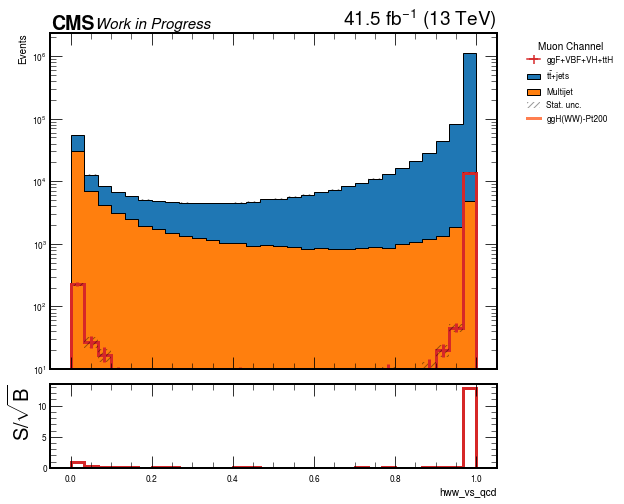

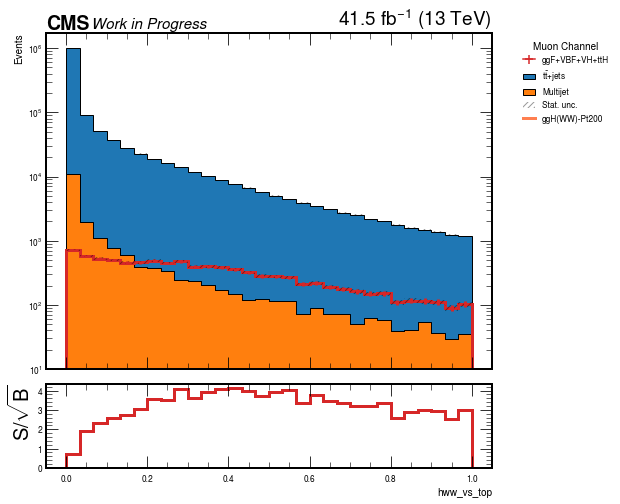

In [40]:
plot_hists(score_hists, score_hists.keys(), add_data = False, logy = True, add_soverb = True, only_sig = False)

Plotting hww_vs_qcd score
  For ParT model
  For PN_v2_noreg model
Plotting hww_vs_top score
  For ParT model
  For PN_v2_noreg model


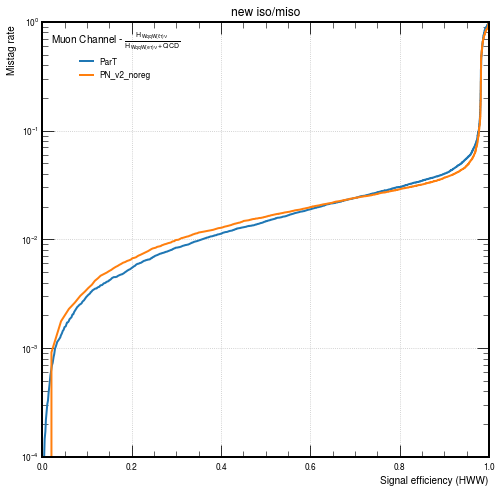

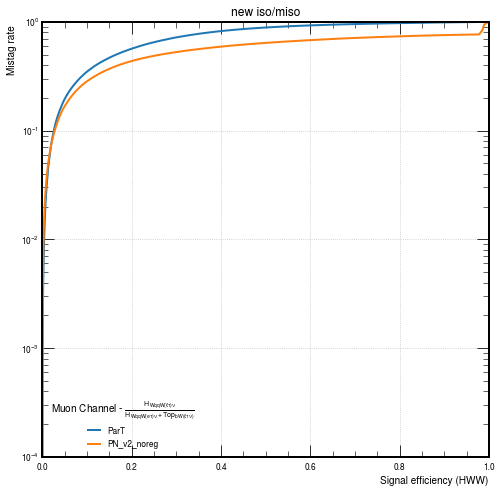

In [41]:
for score in scores[ch].keys():
    print(f"Plotting {score} score")
    fig, ax = plt.subplots(figsize=(8,8))
    ax.grid()
    for pn_version in PNs:
        print(f"  For {pn_version} model")
        
        labels_ = np.array(roc_labels[pn_version][score])
        scores_ = np.array(roc_scores[pn_version][score])

        is_nan = np.isnan(np.array(roc_scores[pn_version][score]))
        if is_nan.sum()!=0:
            print(f"Found {is_nan.sum()} scores out of {len(scores_)}. Will remove them.")
            labels_ = labels_[~is_nan]
            scores_ = scores_[~is_nan]
            
        fpr, tpr, _ = roc_curve(labels_, scores_)
        ax.plot(tpr,fpr,linewidth=2,linestyle='solid',label=pn_version)
    ax.set_xlim(0, 1)
    ax.set_ylim(1e-4,1)
    ax.set_xlabel(f'Signal efficiency (HWW)', fontsize=10, ha='right', x=1)
    #ax.set_ylabel(f'Mistag rate (QCD+WJetsLNu+TT)', fontsize=10, ha='right', y=1)
    ax.set_ylabel(f'Mistag rate ', fontsize=10, ha='right', y=1)
    ax.set_yscale('log')
    xlab = nicex_scores[score]
    xch = nice_channel[ch]
    ax.legend(title=f"{xch} Channel - {xlab}")
    ax.set_title("new iso/miso")

# New task
I have been meaning to get started with this check, basically you can 

- look at the backgrounds after our pre-selection (ttbar, wjets, dyjets, qcd) and see what percentage of them match the labels (the PKU labels and our additional ones)

- For example, Dylan asked this question a couple of times: is our wjets background mostly coming from W-> taunu? or is it W->ev and one electron is being mistagged as jet? To answer this question you could simply plot a distribution e.g. the jet pT and divide the wjets contribution into those MC events that match  (fj_V_taunu==1 & fj_V_isMatched==1), those that match (fj_V_elenu==1 & fj_V_isMatched==1) and those that don't match, https://github.com/cmantill/boostedhiggs/blob/main/boostedhiggs/utils.py#L361

In [42]:
presel = {
    "mu": {
        "mini-iso": "(( (lep_pt < 50) & (lep_isolation < 0.15) ) | (lep_pt >= 50))",
#         "fj_pt": "(fj_pt>400) & (fj_pt<600)",
#         "msd": "( (fj_msoftdrop>60) & (fj_msoftdrop<150) )",
#         "deta": "deta<2.4"
        
    }
}

In [43]:
hists_matching = hist2.Hist(
    hist2.axis.StrCategory([], name="match", growth=True),
    utils.axis_dict["fj_pt"],
)
    
### get samples
samples = os.listdir("../Jan20_2017/")

for sample in samples:

    ### get a combined label to combine samples of the same process
    for key in combine_samples:
        if key in sample:
            sample_to_use = combine_samples[key]
            break
        else:
            sample_to_use = sample

    if "WJets" not in sample_to_use:
        continue

    print(f"Finding {sample} samples and should combine them under {sample_to_use}")

    out_files = f"{samples_dir}/{sample}/outfiles/"
    parquet_files = glob.glob(f"{out_files}/*_{ch}.parquet")
    pkl_files = glob.glob(f"{out_files}/*.pkl")

    if not parquet_files:
        print(f"No parquet file for {sample}")
        continue                

    data = pd.read_parquet(parquet_files)
    not_empty = len(data) > 0

    # apply selection
    print("---> Applying preselection.")
    for selection in presel[ch]:
        print(f"applying {selection} selection on {len(data)} events")
        data = data.query(presel[ch][selection])  
    print("---> Done with preselection.")

    print(f"Will use the remaining {len(data)} events to fill matching hists")

    tau_match = (data["fj_V_taunu"]==1) & (data["fj_V_isMatched"]==1)
    mu_match = (data["fj_V_munu"]==1) & (data["fj_V_isMatched"]==1)
    none_match = (~tau_match) & (~mu_match)

    hists_matching.fill(
        match="tau",
        var=data["fj_pt"][tau_match]
    )
    hists_matching.fill(
        match="mu",
        var=data["fj_pt"][mu_match]
    )
    hists_matching.fill(
        match="unmatched",
        var=data["fj_pt"][none_match]
    )    

Finding WJetsToLNu_HT-100To200 samples and should combine them under WJetsLNu
---> Applying preselection.
applying mini-iso selection on 964 events
---> Done with preselection.
Will use the remaining 958 events to fill matching hists
Finding WJetsToLNu_HT-800To1200 samples and should combine them under WJetsLNu
---> Applying preselection.
applying mini-iso selection on 203619 events
---> Done with preselection.
Will use the remaining 201656 events to fill matching hists
Finding WJetsToLNu_HT-1200To2500 samples and should combine them under WJetsLNu
---> Applying preselection.
applying mini-iso selection on 263660 events
---> Done with preselection.
Will use the remaining 261249 events to fill matching hists
Finding WJetsToLNu_HT-200To400 samples and should combine them under WJetsLNu
---> Applying preselection.
applying mini-iso selection on 95757 events
---> Done with preselection.
Will use the remaining 94964 events to fill matching hists
Finding WJetsToLNu_HT-70To100 samples and sho

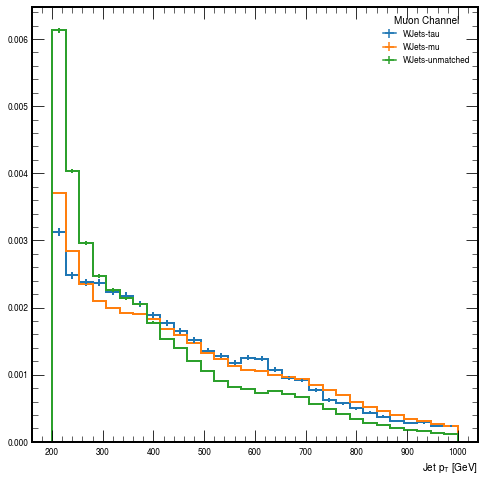

In [44]:
fig, ax = plt.subplots(figsize=(8,8))
for match in ["tau", "mu", "unmatched"]:
    hep.histplot(
        hists_matching[{"match":match}],
        label=f"WJets-{match}",
        ax=ax,
        linewidth=2,
        density=True,
    )
# xlab = nicex_scores[score]
ax.set_xlabel(hists_matching.axes[-1].label)
# xch = nice_channel[ch]
ax.legend(title=f"{xch} Channel")


In [45]:
hists_matching[{"match":"mu"}]

Hist(Regular(30, 200, 1000, name='var', label='Jet $p_T$ [GeV]'), storage=Double()) # Sum: 621951.0 (691595.0 with flow)

In [46]:
hists_matching[{"match":"tau"}]

Hist(Regular(30, 200, 1000, name='var', label='Jet $p_T$ [GeV]'), storage=Double()) # Sum: 34142.0 (38090.0 with flow)